## Create RCNN model and train using train_input.txt

![](fasterrcnn-architecture.png "Title")

#### This whole work is a simple extention to https://github.com/RockyXu66/Faster_RCNN_for_Open_Images_Dataset_Keras

In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import faster_rcnn
from faster_rcnn import RoiPoolingConv
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import pandas as pd
import os

from sklearn.metrics import average_precision_score
import tensorflow
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from tensorflow.keras.losses import categorical_crossentropy

from tensorflow.keras.models import Model
from tensorflow.keras.utils import Progbar
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import initializers, regularizers

### High and low level configuration of model

In [2]:
class Config:

    def __init__(self):

        # Print the process or not
        self.verbose = True

        # Name of base network
        self.network = 'vgg'

        # Setting for data augmentation
        self.use_horizontal_flips = False
        self.use_vertical_flips = False
        self.rot_90 = False

        # Anchor box scales
            # Note that if im_size is smaller, anchor_box_scales should be scaled
            # Original anchor_box_scales in the paper is [128, 256, 512]
        self.anchor_box_scales = [64, 128, 256]

        # Anchor box ratios
        #self.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]
        
        self.anchor_box_ratios = [[1, 1], [1., 2.], [2., 1.], [1., 3.], [3., 1.], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]
                                 

        # Size to resize the smallest side of the image
        # Original setting in paper is 600. Set to 300 in here to save training time
        self.im_size = 300

        # image channel-wise mean to subtract
        self.img_channel_mean = [92.775, 95.355, 92.233]
        self.img_scaling_factor = 1.0

        # number of ROIs at once
        self.num_rois = 4

        # stride at the RPN (this depends on the network configuration)
        self.rpn_stride = 16

        self.balanced_classes = False

        # scaling the stdev
        self.std_scaling = 4.0
        self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

        # overlaps for RPN
        self.rpn_min_overlap = 0.3
        self.rpn_max_overlap = 0.7

        # overlaps for classifier ROIs
        self.classifier_min_overlap = 0.1
        self.classifier_max_overlap = 0.5

        # placeholder for the class mapping, automatically generated by the parser
        self.class_mapping = None

        self.model_path = None

### Parser the data from annotation file

In [3]:
def get_data(input_path):
    """Parse the data from annotation file

    Args:
        input_path: annotation file path

    Returns:
        all_data: list(filepath, width, height, list(bboxes))
        classes_count: dict{key:class_name, value:count_num} 
            e.g. {'Car': 2383, 'Truck': 1108, 'Person': 3745}
        class_mapping: dict{key:class_name, value: idx}
            e.g. {'Car': 0, 'Truck': 1, 'Person': 2}
    """
    found_bg = False
    all_imgs = {}

    classes_count = {}

    class_mapping = {}

    i = 1

    with open(input_path,'r') as f:

        print('Parsing annotation files')

        for line in f:

            # Print process
            sys.stdout.write('\r'+'idx=' + str(i))
            i += 1

            line_split = line.strip().split(',')

            (filename,x1,y1,x2,y2,class_name) = line_split
            #print(filename)          

            if class_name not in classes_count:
                classes_count[class_name] = 1
            else:
                classes_count[class_name] += 1

            if class_name not in class_mapping:
                if class_name == 'bg' and found_bg == False:
                    print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
                    found_bg = True
                class_mapping[class_name] = len(class_mapping)

            if filename not in all_imgs:
                all_imgs[filename] = {}
                img = cv2.imread(filename)
                (rows,cols) = img.shape[:2]
                all_imgs[filename]['filepath'] = filename
                all_imgs[filename]['width'] = cols
                all_imgs[filename]['height'] = rows
                all_imgs[filename]['bboxes'] = []

                all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})


        all_data = []
        for key in all_imgs:
            all_data.append(all_imgs[key])

        # make sure the bg class is last in the list
        if found_bg:
            if class_mapping['bg'] != len(class_mapping) - 1:
                key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping)-1][0]
                val_to_switch = class_mapping['bg']
                class_mapping['bg'] = len(class_mapping) - 1
                class_mapping[key_to_switch] = val_to_switch

        return all_data, classes_count, class_mapping

### Start training

In [4]:
base_path = './'

train_path =  'train_input.txt' # Training data (annotation file)

num_rois = 4 # Number of RoIs to process at once.

# Augmentation flag
horizontal_flips = True # Augment with horizontal flips in training. 
vertical_flips = True   # Augment with vertical flips in training. 
rot_90 = True           # Augment with 90 degree rotations in training. 

output_weight_path = os.path.join(base_path, 'model/model_frcnn_vgg.hdf5')

record_path = os.path.join(base_path, 'model/record.csv') # Record data (used to save the losses, classification accuracy and mean average precision)

base_weight_path = os.path.join(base_path, 'model/vgg16_weights_tf_dim_ordering_tf_kernels.h5')

config_output_filename = os.path.join(base_path, 'model_vgg_config.pickle')

In [5]:
# Create the config
C = Config()

C.use_horizontal_flips = horizontal_flips
C.use_vertical_flips = vertical_flips
C.rot_90 = rot_90

C.record_path = record_path
C.model_path = output_weight_path
C.num_rois = num_rois

C.base_net_weights = base_weight_path

In [6]:
#--------------------------------------------------------#
# This step will spend some time to load the data        #
#--------------------------------------------------------#
st = time.time()
train_imgs, classes_count, class_mapping = get_data(train_path)
print()
print('Spend %0.2f mins to load the data' % ((time.time()-st)/60) )

Parsing annotation files
idx=328185
Spend 9.95 mins to load the data


In [7]:
if 'bg' not in classes_count:
    classes_count['bg'] = 0
    class_mapping['bg'] = len(class_mapping)
# e.g.
#    classes_count: {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745, 'bg': 0}
#    class_mapping: {'Person': 0, 'Car': 1, 'Mobile phone': 2, 'bg': 3}
C.class_mapping = class_mapping

print('Training images per class:')
pprint.pprint(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))
print(class_mapping)

# Save the configuration
with open(config_output_filename, 'wb') as config_f:
    pickle.dump(C,config_f)
    print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(config_output_filename))


Training images per class:
{'animal': 3260,
 'autorickshaw': 22141,
 'bg': 0,
 'bicycle': 1907,
 'bus': 11293,
 'car': 55645,
 'caravan': 32,
 'motorcycle': 67582,
 'person': 61023,
 'rider': 63918,
 'traffic light': 2571,
 'traffic sign': 8588,
 'trailer': 4,
 'train': 34,
 'truck': 17238,
 'vehicle fallback': 12949}
Num classes (including bg) = 16
{'truck': 0, 'vehicle fallback': 1, 'car': 2, 'motorcycle': 3, 'rider': 4, 'person': 5, 'bus': 6, 'bicycle': 7, 'autorickshaw': 8, 'animal': 9, 'traffic sign': 10, 'train': 11, 'traffic light': 12, 'caravan': 13, 'trailer': 14, 'bg': 15}
Config has been written to ./model_vgg_config.pickle, and can be loaded when testing to ensure correct results


In [8]:
# Shuffle the images with seed
random.seed(1)
random.shuffle(train_imgs)

print('Num train samples (images) {}'.format(len(train_imgs)))

Num train samples (images) 21458


In [9]:
def get_img_output_length(width, height):
    def get_output_length(input_length):
        return input_length//16

    return get_output_length(width), get_output_length(height)  

In [10]:
# Get train data generator which generate X, Y, image_data
data_gen_train = faster_rcnn.get_anchor_gt(train_imgs, C, get_img_output_length, mode='train')

#### Build the model

In [13]:
input_shape_img = (None, None, 3)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = faster_rcnn.nn_base(img_input, trainable=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios) # 9
rpn = faster_rcnn.rpn_layer(shared_layers, num_anchors)

classifier = faster_rcnn.classifier_layer(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count))

model_rpn = Model(img_input, rpn[:2])
model_classifier = Model([img_input, roi_input], classifier)

# this is a model that holds both the RPN and the classifier, used to load/save weights for the models
model_all = Model([img_input, roi_input], rpn[:2] + classifier)

# Because the google colab can only run the session several hours one time (then you need to connect again), 
# we need to save the model and load the model to continue training
if not os.path.isfile(C.model_path):
    #If this is the begin of the training, load the pre-traind base network such as vgg-16
    try:
        print('This is the first time of your training')
        print('loading weights from {}'.format(C.base_net_weights))
        model_rpn.load_weights(C.base_net_weights, by_name=True)
        model_classifier.load_weights(C.base_net_weights, by_name=True)
    except:
        print('Could not load pretrained model weights. Weights can be found in the keras application folder \
            https://github.com/fchollet/keras/tree/master/keras/applications')
    
    # Create the record.csv file to record losses, acc and mAP
    record_df = pd.DataFrame(columns=['mean_overlapping_bboxes', 'class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'loss_class_cls', 'loss_class_regr', 'curr_loss', 'elapsed_time', 'mAP'])
else:
    # If this is a continued training, load the trained model from before
    print('Continue training based on previous trained model')
    print('Loading weights from {}'.format(C.model_path))
    model_rpn.load_weights(C.model_path, by_name=True)
    model_classifier.load_weights(C.model_path, by_name=True)
    
    # Load the records
    record_df = pd.read_csv(record_path)

    r_mean_overlapping_bboxes = record_df['mean_overlapping_bboxes']
    r_class_acc = record_df['class_acc']
    r_loss_rpn_cls = record_df['loss_rpn_cls']
    r_loss_rpn_regr = record_df['loss_rpn_regr']
    r_loss_class_cls = record_df['loss_class_cls']
    r_loss_class_regr = record_df['loss_class_regr']
    r_curr_loss = record_df['curr_loss']
    r_elapsed_time = record_df['elapsed_time']
    r_mAP = record_df['mAP']

    print('Already train %dK batches'% (len(record_df)))

This is the first time of your training
loading weights from ./model/vgg16_weights_tf_dim_ordering_tf_kernels.h5


In [15]:
optimizer = Adam(lr=1e-5)
optimizer_classifier = Adam(lr=1e-5)
model_rpn.compile(optimizer=optimizer, loss=[faster_rcnn.rpn_loss_cls(num_anchors), faster_rcnn.rpn_loss_regr(num_anchors)])
model_classifier.compile(optimizer=optimizer_classifier, loss=[faster_rcnn.class_loss_cls, faster_rcnn.class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
model_all.compile(optimizer='sgd', loss='mae')

In [16]:
# Training setting
total_epochs = len(record_df)
r_epochs = len(record_df)

epoch_length = 1000
num_epochs = 300
iter_num = 0

total_epochs += num_epochs

losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []

if len(record_df)==0:
    best_loss = np.Inf
else:
    best_loss = np.min(r_curr_loss)

In [17]:
print(len(record_df))

0


## Below cell is the most important
<li>get image</li>
<li>pass through RPN model</li>
<li>use the output of the RNP model and pass it to ROI layer</li>
<li>ROI layer outputs some Regions of interest</li>
<li>declare positive and negative sample based on threshold of IOU</li>
<li>pass both positive and negative samples to classifier layer</li>
<li>classifier layer decides which image belong to which class and the boundary box</li>

#### We train two models here
<b>
    <li>RPN layer</li>
    <li>Classifier layer</li>
</b>

In [ ]:
start_time = time.time()
for epoch_num in range(num_epochs):

    progbar = Progbar(epoch_length)
    print('Epoch {}/{}'.format(r_epochs + 1, total_epochs))
    
    r_epochs += 1

    while True:
        try:

            if len(rpn_accuracy_rpn_monitor) == epoch_length and C.verbose:
                mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
                rpn_accuracy_rpn_monitor = []
    #                 print('Average number of overlapping bounding boxes from RPN = {} for {} previous iterations'.format(mean_overlapping_bboxes, epoch_length))
                if mean_overlapping_bboxes == 0:
                    print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')

            # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
            X, Y, img_data, debug_img, debug_num_pos = next(data_gen_train)

            # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
            loss_rpn = model_rpn.train_on_batch(X, Y)

            # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
            P_rpn = model_rpn.predict_on_batch(X)

            # R: bboxes (shape=(300,4))
            # Convert rpn layer to roi bboxes
            R = faster_rcnn.rpn_to_roi(P_rpn[0], P_rpn[1], C, use_regr=True, overlap_thresh=0.7, max_boxes=300)

            # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
            # X2: bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
            # Y1: one hot code for bboxes from above => x_roi (X)
            # Y2: corresponding labels and corresponding gt bboxes
            X2, Y1, Y2, IouS = faster_rcnn.calc_iou(R, img_data, C, class_mapping)

            # If X2 is None means there are no matching bboxes
            if X2 is None:
                rpn_accuracy_rpn_monitor.append(0)
                rpn_accuracy_for_epoch.append(0)
                continue

            # Find out the positive anchors and negative anchors
            neg_samples = np.where(Y1[0, :, -1] == 1)
            pos_samples = np.where(Y1[0, :, -1] == 0)

            if len(neg_samples) > 0:
                neg_samples = neg_samples[0]
            else:
                neg_samples = []

            if len(pos_samples) > 0:
                pos_samples = pos_samples[0]
            else:
                pos_samples = []

            rpn_accuracy_rpn_monitor.append(len(pos_samples))
            rpn_accuracy_for_epoch.append((len(pos_samples)))

            if C.num_rois > 1:
                # If number of positive anchors is larger than 4//2 = 2, randomly choose 2 pos samples
                if len(pos_samples) < C.num_rois//2:
                    selected_pos_samples = pos_samples.tolist()
                else:
                    selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()

                # Randomly choose (num_rois - num_pos) neg samples
                try:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
                except:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()

                # Save all the pos and neg samples in sel_samples
                sel_samples = selected_pos_samples + selected_neg_samples
            else:
                # in the extreme case where num_rois = 1, we pick a random pos or neg sample
                selected_pos_samples = pos_samples.tolist()
                selected_neg_samples = neg_samples.tolist()
                if np.random.randint(0, 2):
                    sel_samples = random.choice(neg_samples)
                else:
                    sel_samples = random.choice(pos_samples)

            # training_data: [X, X2[:, sel_samples, :]]
            # labels: [Y1[:, sel_samples, :], Y2[:, sel_samples, :]]
            #  X                     => img_data resized image
            #  X2[:, sel_samples, :] => num_rois (4 in here) bboxes which contains selected neg and pos
            #  Y1[:, sel_samples, :] => one hot encode for num_rois bboxes which contains selected neg and pos
            #  Y2[:, sel_samples, :] => labels and gt bboxes for num_rois bboxes which contains selected neg and pos
            loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])

            losses[iter_num, 0] = loss_rpn[1]
            losses[iter_num, 1] = loss_rpn[2]

            losses[iter_num, 2] = loss_class[1]
            losses[iter_num, 3] = loss_class[2]
            losses[iter_num, 4] = loss_class[3]

            iter_num += 1

            progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                      ('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3]))])

            if iter_num == epoch_length:
                loss_rpn_cls = np.mean(losses[:, 0])
                loss_rpn_regr = np.mean(losses[:, 1])
                loss_class_cls = np.mean(losses[:, 2])
                loss_class_regr = np.mean(losses[:, 3])
                class_acc = np.mean(losses[:, 4])

                mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                rpn_accuracy_for_epoch = []

                if C.verbose:
                    print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                    print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                    print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                    print('Loss RPN regression: {}'.format(loss_rpn_regr))
                    print('Loss Detector classifier: {}'.format(loss_class_cls))
                    print('Loss Detector regression: {}'.format(loss_class_regr))
                    print('Total loss: {}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
                    print('Elapsed time: {}'.format(time.time() - start_time))
                    elapsed_time = (time.time()-start_time)/60

                curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                iter_num = 0
                start_time = time.time()
                if curr_loss < best_loss:
                    if C.verbose:
                        print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                    best_loss = curr_loss
                    model_all.save_weights('model/Epoch_'+str(1+epoch_num)+'.hdf5')

                new_row = {'mean_overlapping_bboxes':round(mean_overlapping_bboxes, 3), 
                           'class_acc':round(class_acc, 3), 
                           'loss_rpn_cls':round(loss_rpn_cls, 3), 
                           'loss_rpn_regr':round(loss_rpn_regr, 3), 
                           'loss_class_cls':round(loss_class_cls, 3), 
                           'loss_class_regr':round(loss_class_regr, 3), 
                           'curr_loss':round(curr_loss, 3), 
                           'elapsed_time':round(elapsed_time, 3), 
                           'mAP': 0}

                record_df = record_df.append(new_row, ignore_index=True)
                record_df.to_csv(record_path, index=0)

                break

        except Exception as e:
            #print('Exception: {}'.format(e))
            print(e,end="")
            continue
#             print("asdasdasdasdasdasdasdasdasdasdasdasdas")
#             print(e)
print('Training complete, exiting.')

Epoch 1/300
1000/1000 [==============================] - 730s 730ms/step - rpn_cls: 3.1622 - rpn_regr: 0.4585 - final_cls: 1.4046 - final_regr: 0.7284nnot be empty unless no samples are ta'a' cann'a' cannot be empty unless no samples are taken'a' cannot be empty unl'a' cannot be empty unless no sam'a' cannot be empty unless no sam'a' cannot be empty unless no'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are taken'a' cannot be empty'a' cannot be empty unless no samples a'a' cannot be empty unl'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are'a' cannot

1000/1000 [==============================] - 606s 606ms/step - rpn_cls: 2.3858 - rpn_regr: 0.3957 - final_cls: 0.5717 - final_regr: 0.2266nnot be empty unless no samples are takent be e'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples''a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are'a' cannot be empty unless 'a' cannot be empty unless no samples are t'a' cannot be empty unless no samp

1000/1000 [==============================] - 591s 591ms/step - rpn_cls: 1.9606 - rpn_regr: 0.3724 - final_cls: 0.6382 - final_regr: 0.1674nnot be empty unless no samples are takeno samples are t'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are t'a' cannot be empty unless 'a' cannot be empty unless no samples'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples a'a' cannot be empty unless no samples are tak'a' cannot be empty'a' cannot be empty unless no samples are'a' cannot be empty unless no samples are tak'a' cannot be empty unless 'a' cannot be empty'a' cannot be empty unless no samples are'a' cannot be empty unless no samples a'a' cannot be empty unless no samples are'a' cannot be empty unless no s'a' cannot be empty unless 'a' cannot be empty unless no samples are'a' cannot be empty unless no sampl'a' cannot be empty unless no samples a'a' cannot be empty unless no samples are tak'a''a' cannot be empty unless no 

1000/1000 [==============================] - 574s 574ms/step - rpn_cls: 1.9177 - rpn_regr: 0.3944 - final_cls: 0.5413 - final_regr: 0.1061nnot be empty unless no samples are taken'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are ta'a' cannot be empty unless no sample'a' cannot be empty unless no sampl'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are ta'a' cannot be empty unless no samples a'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are 'a' cannot be empty unless no sample'a' cannot be empty unl'a' cannot 'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are tak'a' cannot be empty unles'a' cannot be empty unless no samples are taken'a' cannot be empty unless no sampl'a' cannot be empty unless no samples'a' cannot be empty unless no samples are 

1000/1000 [==============================] - 579s 579ms/step - rpn_cls: 1.7058 - rpn_regr: 0.3617 - final_cls: 0.6634 - final_regr: 0.1229nnot be empty unless no s'a''a' cannot be e'a' cannot be empty unless no samples are'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples'a' cannot be empty unless no'a' cannot be empty unless no samples are'a' cannot be empty unless no samples are t'a' canno'a' cannot be emp'a' cannot be empty unless no samples'a' cannot be empty unless no samples'a' cannot be empty unless no samples are t''a' cannot be empty unless no samples are'a' cannot be empty unless no samples are'a' cannot be empty unless 'a' cannot be empty unless no samples are'a' cannot be empty unless no samples'a' cannot be empty unless no sam'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are taken'a' cannot be empty unless no sampl'a' cannot be empty unless no samples are tak'a' cannot be emp'a' cannot be empty unles'a' canno

1000/1000 [==============================] - 547s 547ms/step - rpn_cls: 1.7761 - rpn_regr: 0.3687 - final_cls: 0.7550 - final_regr: 0.1445nnot be empty unless no samples are taken'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are ta'a' cannot be empty unless no samples ar'a' cannot be empty unless no samples are ta'a' cannot be empty unless no samples are take'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples'a' cannot be empty unless no samples'a' cannot be empty 'a' cannot be empty unless no s'a' cannot be empty unless no samples are'a' cannot be empty unless no samples are'a' cannot be empty u'a' cannot be empty unless no sampl'a' cannot be empty unless no samples are t'a' cannot be empty u'a' cannot be'a' cannot be e'a' cannot be empty unless 'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are tak'a' cannot be empty'a' cannot be empty unless no samples are taken'a' cannot be empty

Epoch 15/300
1000/1000 [==============================] - 519s 519ms/step - rpn_cls: 1.6129 - rpn_regr: 0.3699 - final_cls: 0.7349 - final_regr: 0.1271nnot be empty unless no samples are taken'a' cannot be empt'a' cannot be empty'a'a' cannot be empty unless no samples are'a' cannot be empty unless no samples a'a' cannot be empty unless no sampl'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are'a' cannot be empty unless no samples are'a' cannot be empty unless no samples a'a' cannot 'a' cannot be emp'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples'a' cannot be empty unless no sam'a' cannot be empty unless no samples are taken'a' cannot be empty unles'a' cannot be empty unless no samples are taken'a' cannot be'a' cannot be empty unles'a' cannot be empty unles'a' cannot be empty unless no'a' cannot be empty un'a' cannot be empty unless no samples a'a' cannot be empty unless no 

1000/1000 [==============================] - 540s 540ms/step - rpn_cls: 1.5395 - rpn_regr: 0.3493 - final_cls: 0.7480 - final_regr: 0.1338nnot be empty unless no samples are takenot 'a''a' cannot be empty unless no sa'a' cannot be empty unless no samples are t'a' 'a' cannot be empty unless no samples are t'a' canno'a' cannot be empty unless 'a' cannot be empty unless 'a' cannot be empty unles'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples a'a' cannot be empty unless no samples a'a' cannot be empty unless 'a' cannot be empty unless no'a' cannot be empty unless no samples'a' cannot be'a' cannot be empty unless no samples are'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are t'a' cannot be empty u'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are'a' cannot be empty unless no s'a' cannot be e'a' cannot be empty unless no samples are tak'a

1000/1000 [==============================] - 532s 532ms/step - rpn_cls: 1.3871 - rpn_regr: 0.3419 - final_cls: 0.7676 - final_regr: 0.1513nnot be empty unless no samples a'a' cannot be empty unless no samples 'a' cannot be empty unless no samples are tak'a' cannot be empty unless no sampl'a' cannot be empty u'a' cannot be'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are t'a' cannot be empty unless no sam'a' cannot be empty unless no'a' cannot be empty unless no sam'a' cannot be empty'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are t'a' cannot be empty unless no s'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are taken'a' cannot be empty unless no sampl'a' can'a' cannot be empty unless no samples a'a' cannot be empty unless no samples'a' cannot be'a' cannot be empty unless no samples are taken'a' cannot 'a' cannot be empty unless no sa

1000/1000 [==============================] - 516s 516ms/step - rpn_cls: 1.2479 - rpn_regr: 0.3385 - final_cls: 0.6982 - final_regr: 0.1254annot be empty unless no samples are 'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples a'a' cannot be empty unless no'a' cannot be empty unless no sa'a' cannot be empty unless no samples'a' cannot be empty unless no'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samp'a' cannot be emp'a' cannot be empty unless no samples'a' cannot be empty'a' cannot be empty unless no samples are t'a' cannot be empty unl'a' 'a' cannot be empty unless no sam'a' cannot be empty unless 'a' cannot be empty unless no samples ar'a' cannot be empty unless no'a' cannot be empty unless no samples are taken'a' cannot be empty unless no sampl'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are tak'a' cannot be empty unless 'a' cannot be empty unless no sampl'a' cannot be empty'a' cann

1000/1000 [==============================] - 545s 545ms/step - rpn_cls: 1.4405 - rpn_regr: 0.3341 - final_cls: 0.7104 - final_regr: 0.1512nnot be empty unless no samples are tak'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are t'a' cannot be empty 'a' cannot be empty unl'a' cannot be empty unless no s'a' cannot be empty unless 'a' cannot be empty unless no samples are t'a' cannot be empty unl''a' cannot be empty unless no samples are tak'a' cannot be empty unless no'a' cannot be empty unless no samples are taken'a' cannot be empty'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are tak'a' cannot be empty unless no sampl'a' cannot be empty unless no samples'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples'a' cannot be empty unless no samples are t'a'

1000/1000 [==============================] - 528s 528ms/step - rpn_cls: 1.2285 - rpn_regr: 0.3529 - final_cls: 0.7646 - final_regr: 0.1469nnot be empty'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are tak'a' cannot be empty unless no sampl'a' cannot be empty unless no samples are'a' cannot be empty unless no sampl'a' cannot be empty unles'a' cannot be e'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples a'a' cannot be e'a' cannot be empty unless no sam'a' cannot be empty unless no samples are taken'a' cannot be empty unles'a' cannot be empty unless no samples are t'a' cannot be empty unless no'a' cannot be empty unless no s'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are'a' cannot be empty u'a' cannot be empty unless 'a' cannot be'a' cannot be empty unless no samples are taken'a' cann'a' cannot be empty unless no sampl'a' cannot be empty unless no samples are tak'a' cannot be emp

1000/1000 [==============================] - 501s 501ms/step - rpn_cls: 1.2466 - rpn_regr: 0.3050 - final_cls: 0.8379 - final_regr: 0.1509nnot be empty u'a' cannot be empty unless no'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples'a' c'a' cannot be empty unless no''a' cannot be empty unless no samples a'a' cannot be empty unless no sam'a' cannot be empty unless no samples are tak'a' cannot be empty unless no sampl'a' cannot be empty unless no samples are tak'a' cannot be empty'a' cannot 'a' cannot be empty unless no samples are taken'a' cannot be empty unless no'a' cannot be empty unless no 'a' cannot be empty unless no samples are tak'a' can'a' cannot be empty unless no sam'a' canno'a' cannot 'a' cannot be empty unless no samples are taken'a' cannot be empty unless no'a' cannot be empty unless no sampl'a' cannot be empty unles'a' cannot be empty unless no samples are'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are'a

1000/1000 [==============================] - 509s 509ms/step - rpn_cls: 1.3050 - rpn_regr: 0.3056 - final_cls: 0.7720 - final_regr: 0.1540nnot be empty unless no samples are taken'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are'a' cannot be empty unless no samples'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are tak'a' cannot be empty unless no sam'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples a'a' cannot be empty unless no samples are'a' canno'a' cannot be empty unless no s'a''a' cannot be empty unless no samples are taken'a'a' cannot be empty'a' cannot be empty unless no sam'a' cannot be empty unless no sample'a' cannot be empty unless no samples are taken'a' cannot be empty unless no s'a' cannot be empty unless no samples are t'a' cannot be empty unle

Epoch 44/300
1000/1000 [==============================] - 525s 525ms/step - rpn_cls: 1.1352 - rpn_regr: 0.3134 - final_cls: 0.7976 - final_regr: 0.1680nnot be empty unless no samples'a' cannot be empty unless no samples are t'a' cannot be empty unless no'a' cannot be empty unless no sam'a' cannot be empty unless no sam'a' cannot be empty unless no samples'a' cannot be empty unless no'a' cannot be empty unless no samples'a' cannot be empty unl'a' can'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples a'a' cannot be empty unless no samples are'a' cannot be empty unl'a' cannot be empty unless no samples are'a' cannot be empty unless no sampl'a' cannot be empty unless no sampl'a' cannot be empty unless no samples a'a' cannot be empty unless no sample'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are

1000/1000 [==============================] - 502s 502ms/step - rpn_cls: 1.0493 - rpn_regr: 0.2800 - final_cls: 0.7934 - final_regr: 0.1699' cannot be empty unless no samples a'a' cannot be empty unless no samples are take'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are ta'a' cannot be empty unless no samples ar'a' cannot be emp'a' ca'a' cannot be e'a' cannot be empty unless no samples'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are 'a' cannot be empty unless no samples are tak'a' c'a' cannot b'a' cannot be empty unless no s'a' cannot be e'a' cannot be empty unless no samples a'a''a' cannot be empty unless no samples are t'a' cannot be empty unless no samples a'a' cannot be empty unless no samples'a' cannot be empty unless 'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples'a' cannot be empty unless 'a' cannot be empty unless no samples are 

1000/1000 [==============================] - 568s 568ms/step - rpn_cls: 1.1042 - rpn_regr: 0.2904 - final_cls: 0.8259 - final_regr: 0.1764nnot be empty unless no samples are t'a' cannot be empty unless no samples are tak'a' cannot be empty un'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are'a' cannot be empty unless no'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are t'a' cannot be empty unl'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples a'a' cannot be empty unless no samples are t'a' cannot be empty unless 'a' cannot be'a' cannot be empty unles'a' cannot be empty unl'a' cannot be empty unless no samples are'a' cannot be empty unless no sam'a' cannot be empty unless no s'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples'a' cannot be empty u''a' cannot be empty unless no samples'a' cannot be empty unless no samples are t'a' cannot be empty unless no 

1000/1000 [==============================] - 498s 498ms/step - rpn_cls: 0.9869 - rpn_regr: 0.3054 - final_cls: 0.7996 - final_regr: 0.1776nnot be empty unless no samples are tak'a' cannot be empty unless no samples are t'a' cannot be empty'a' cannot be empty unless no sampl'a' cannot be empty unles'a' cannot be empty unless no samples'a' cannot be empty unless no samples a'a' cannot be e'a' cannot be empty unless no samples are t'a' cannot be empty unless no sampl'a' cannot be empty u'a' cannot be empty unless no samples'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are tak'a' cannot be empty unless no sampl'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are'a' cannot be empty unless no sampl'a' cannot be empty unless no samples are taken'a' cannot be empty unless no sam'a' cannot be empty unles'a' cannot be em'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are taken'a' cannot be

1000/1000 [==============================] - 512s 512ms/step - rpn_cls: 0.9838 - rpn_regr: 0.2983 - final_cls: 0.7364 - final_regr: 0.1711nnot be empty unl'a' cannot be empty unless no'a' cannot be empty unless no samples are tak'a' ca'a' cannot 'a' cannot 'a''a' cannot be empty unless no s'a' cannot be empty unless 'a' cannot be empty unless no samples a'a' cannot be empty unless no s'a' cannot be empty unless no samples a'a' cannot be empty unless no samples are tak'a' cannot be empty unless 'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are taken'a' cannot be empty unless no sampl'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are taken'a' cannot be'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are taken'a' cannot be e'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples a'a' cannot be empty unless no samples are t'a' cannot be empty unless no sam

1000/1000 [==============================] - 490s 490ms/step - rpn_cls: 0.9540 - rpn_regr: 0.2946 - final_cls: 0.7710 - final_regr: 0.1899   'a' cannot be empty unless no samples are'a' cannot be empt'a' cannot be empty unless no sam'a' cannot be empty unless no sam'a' cannot be empty unless 'a' cannot be empty unless no samples are tak'a' cannot be'a' cannot be empty unless no sampl'a''a' cannot be empty unless 'a' cannot be empty unless no s'a' cannot be empty unl'a' cannot 'a' cannot be empty unless no samples'a' cannot be empty u'a' cannot be empty unless no samples'a' cannot be empty u'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are taken'a' cannot be empty unless no s'a' cannot be empty unles'a' cannot be empty unless 'a' cannot be empty unless no samples'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples'a' cannot be empty'a' cannot be empty unless no sampl'a' cannot

1000/1000 [==============================] - 482s 482ms/step - rpn_cls: 0.9497 - rpn_regr: 0.2719 - final_cls: 0.7749 - final_regr: 0.1666nnot be empty unless no samples a'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples'a' cannot be empty unless no sampl'a' cannot be empty unless no samples are taken'a' cannot be ''a' cannot be empty unless no sampl'a' cannot be 'a' cannot be empty unles'a' cannot be empty unl'a' c''a' cannot be empty unless no samples are t'a' cannot be empty 'a' cannot be empty unless no sa''a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are t'a' cannot be empty unless no sam'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are taken'a' cannot be empty unless no samples are taken'a' cannot be empty unless 'a' cannot be empty unless no samples 'a' cannot be empty unless no sample

1000/1000 [==============================] - 499s 499ms/step - rpn_cls: 0.7923 - rpn_regr: 0.2667 - final_cls: 0.7882 - final_regr: 0.1817nnot be empty unless no sam'a' cannot be em'a' cannot be empty unle'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples'a' cannot be empty unles'a' cannot be empty unless no sampl'a' cannot be empty unless no 'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples'a' cannot be e'a' cannot be empty unless no samples are t'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are t'a' cannot be empty unl'a' c'a' cannot be empty unless no sam'a' cannot be empty unless no samples are t'a' cannot be empty unless no s'a' can'a' cannot be empty unless no samples are'a''a' cannot be empty unl'a' cannot be empty unless no samples a'a' cannot be empty unless no sampl'a' cannot be empty unless no sam'a' cannot be emp'a' cannot be em'a' c

 459/1000 [============>.................] - ETA: 4:31 - rpn_cls: 0.7657 - rpn_regr: 0.2613 - final_cls: 0.7548 - final_regr: 0.1625'a' cannot be empty unles'a' cannot be empty unless no sampl'a' cannot be empty un'a' cannot be empty unless no'a' c'a' cannot be e'a' cannot be empty unless 'a' c'a' cannot be empty unl'a' cannot be empty unless no samples'a' cannot 'a' cannot be empty unless no'a' cannot be empty unless no samples are tak'a' cannot be empty unless no samples are t'a' cannot be empty 'a' cannot be 'a' cannot be empty unless no samples are t'a' cannot be empty unless no sample'a' cannot be empty unless no samples are'a' cannot be e'a' cannot be empty unless no samples

### Plot loss of individual models and combined loss as well

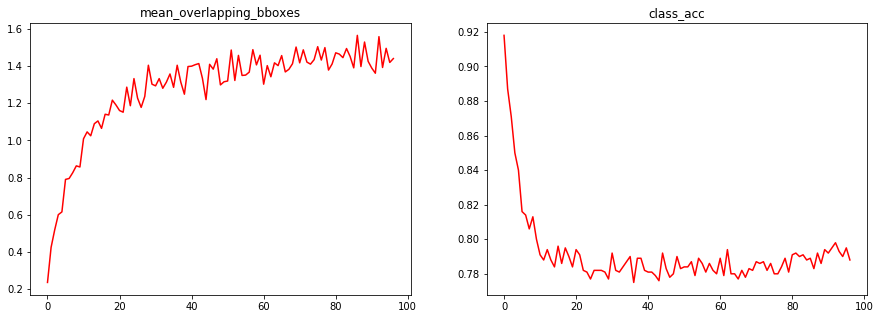

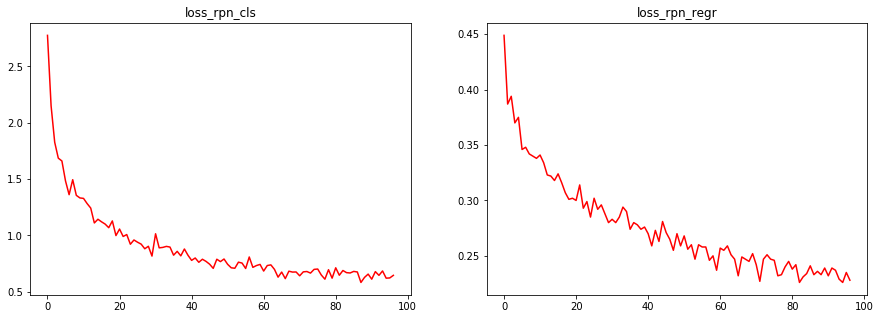

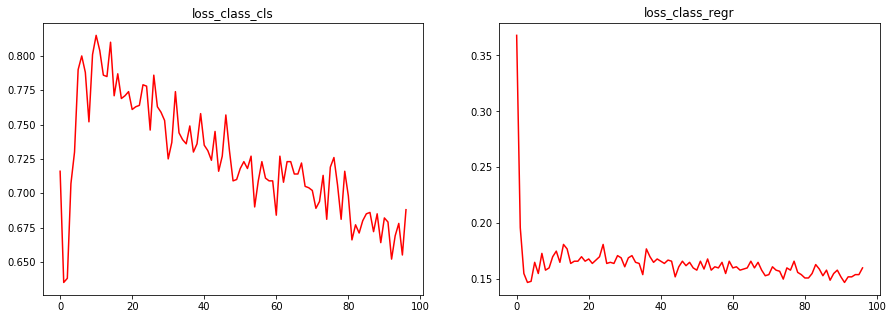

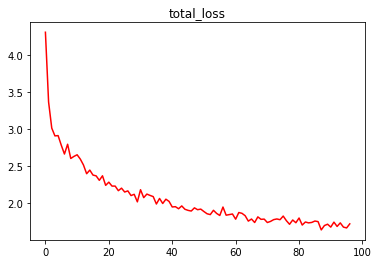

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()

plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')
plt.show()

`Though loss is decressing, due to some hard ware problem my computer got shutdowned automatically at epoch 80. I will continue with map calculation with the last epoch model. Surely more training can do more better results.`